  Introduction

**Imports**

In [1]:
import kagglehub

import os

import torch
import torch.nn as nn
import torch.optim as optim

import torchvision
from torchvision import transforms

from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision import models


import random
import matplotlib.pyplot as plt
import cv2


In [2]:
# Setup device-agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

**Data Processing**

In [3]:
# Download latest version
path = kagglehub.dataset_download("puneet6060/intel-image-classification")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/intel-image-classification


In [4]:
import os
def walk_through_dir(dir_path):

  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

In [5]:
walk_through_dir(path)

There are 3 directories and 0 images in '/kaggle/input/intel-image-classification'.
There are 1 directories and 0 images in '/kaggle/input/intel-image-classification/seg_train'.
There are 6 directories and 0 images in '/kaggle/input/intel-image-classification/seg_train/seg_train'.
There are 0 directories and 2512 images in '/kaggle/input/intel-image-classification/seg_train/seg_train/mountain'.
There are 0 directories and 2382 images in '/kaggle/input/intel-image-classification/seg_train/seg_train/street'.
There are 0 directories and 2191 images in '/kaggle/input/intel-image-classification/seg_train/seg_train/buildings'.
There are 0 directories and 2274 images in '/kaggle/input/intel-image-classification/seg_train/seg_train/sea'.
There are 0 directories and 2271 images in '/kaggle/input/intel-image-classification/seg_train/seg_train/forest'.
There are 0 directories and 2404 images in '/kaggle/input/intel-image-classification/seg_train/seg_train/glacier'.
There are 1 directories and 0 i

In [6]:
train_path = os.path.join(path, "seg_train/seg_train")
test_path = os.path.join(path, "seg_test/seg_test")

In [7]:
def show_random_image(iamge_folder):
    """
    Function to display a random image from a random category in the training folder.
    """
    # Get a random category
    categories = os.listdir(iamge_folder)
    random_category = random.choice(categories)

    # Get a random image from the selected category
    image_folder = os.path.join(iamge_folder, random_category)
    image_name = random.choice(os.listdir(image_folder))
    image_path = os.path.join(image_folder, image_name)

    # Load and display the image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to correct color format
    plt.imshow(image)
    plt.title(f"Category: {random_category}")
    plt.axis("off")
    plt.show()

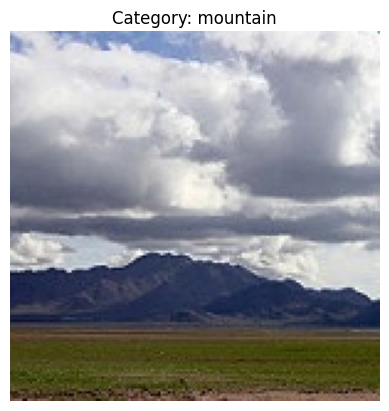

In [8]:
show_random_image(train_path)

In [9]:
simple_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),  # Convert image to PyTorch tensor
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

In [10]:
train_data = ImageFolder(root=train_path, transform=simple_transforms)
test_data = ImageFolder(root=test_path, transform=simple_transforms)

train_dataloader = DataLoader(train_data, batch_size=32, shuffle=True, num_workers=4)
test_dataloader = DataLoader(test_data, batch_size=32, shuffle=False)

In [11]:
img, label = next(iter(train_dataloader))
print(f"Image shape: {img.shape}")
print(f"Label: {label}")

Image shape: torch.Size([32, 3, 224, 224])
Label: tensor([1, 2, 3, 0, 3, 3, 1, 3, 4, 3, 0, 3, 3, 3, 4, 4, 4, 3, 3, 0, 4, 0, 3, 0,
        2, 2, 1, 5, 1, 3, 2, 2])


In [12]:
for images, labels in train_dataloader:
    # Check for NaN or Inf values
    if torch.isnan(images).any():
        print("NaN detected in input!")
    if torch.isinf(images).any():
        print("Inf detected in input!")


**CNN feature extraction**

Why Use a CNN Feature Extractor?

---


*   ✅ Captures Local Patterns – CNNs are great at extracting edges, textures, shapes, and spatial hierarchies.
*   ✅ Reduces Input Complexity – Instead of feeding raw pixel values into the transformer, CNNs generate compact feature maps.
*   ✅ Improves Computational Efficiency – Using a CNN reduces the number of computations required in the ViT model.







In [13]:
class CNNFeatureExtractor(nn.Module):
    def __init__(self):
        super().__init__()
        self.cnn = models.resnet50(weights="IMAGENET1K_V1")  # Load pre-trained ResNet50
        self.cnn = nn.Sequential(*list(self.cnn.children())[:-2])  # Keep spatial feature maps

    def forward(self, x):
        x = self.cnn(x)  # Output shape: (batch, channels, height, width)
        return x

**Feature Refinement**

In [14]:
class PatchEmbedding(nn.Module):
    def __init__(self, in_channels=2048, patch_size=1, embed_dim=512):
        super().__init__()
        self.projection = nn.Conv2d(in_channels, embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        batch_size, channels, h, w = x.shape  # CNN output shape (batch, 2048, 7, 7)

        x = self.projection(x)  # Reduce from 2048 channels to 512
        _, embed_dim, new_h, new_w = x.shape  # New shape after projection

        num_patches = new_h * new_w  # Should be 49 patches for 7x7
        x = x.flatten(2).transpose(1, 2)  # Convert to (batch, num_patches, embed_dim)

        return x  # Correct shape: (batch, 49, 512)

class PositionalEncoding(nn.Module):
    def __init__(self, embed_dim=512, num_patches=49):  # Fix embed_dim
        super().__init__()
        self.pe = nn.Parameter(torch.randn(1, num_patches, embed_dim))  # Ensure correct size

    def forward(self, x):
        return x + self.pe[:, :x.size(1), :]  # Match embedding dimension


**Transformer Processing**

In [15]:
class TransformerEncoder(nn.Module):
    def __init__(self, embed_dim=512, num_heads=8, num_layers=6):
        super().__init__()
        encoder_layer = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

    def forward(self, x):
        # print(f"Transformer Input: {x.shape}")  # Debug shape before Transformer
        x = self.transformer(x)  # Apply transformer layers
        # print(f"Transformer Output: {x.shape}")  # Debug shape after Transformer
        return x

**Classification Layer**

In [31]:
class ClassificationHead(nn.Module):
    def __init__(self, embed_dim=512, num_classes=6):
        super().__init__()
        self.dropout = nn.Dropout(p=0.3)  # Apply dropout
        self.fc = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
        x = self.dropout(x.mean(dim=1))  # Apply dropout
        return self.fc(x)  # Aggregate token outputs before classification


In [32]:
class HybridCNNViT(nn.Module):
    def __init__(self, num_classes=6):
        super().__init__()
        self.cnn = CNNFeatureExtractor()  # CNN Feature Extraction
        self.patch_embed = PatchEmbedding()
        self.pos_enc = PositionalEncoding()
        self.transformer = TransformerEncoder()
        self.classifier = ClassificationHead(num_classes=num_classes)

    def forward(self, x):
        features = self.cnn(x)
        # print('features', features.shape)
        patches_embed = self.patch_embed(features)
        # print('patches_embed', patches_embed.shape)
        patches_enc = self.pos_enc(patches_embed)
        # print('patches_enc', patches_enc.shape)
        output = self.transformer(patches_enc)
        return self.classifier(output)

**Training loop**

In [33]:
model = HybridCNNViT(num_classes=6).to(device)

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


In [34]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-6, weight_decay=1e-4)


scaler = torch.amp.GradScaler()  # Initialize AMP

num_epoch = 10

for epoch in range(num_epoch):
    model.train()
    total_loss = 0.0
    for batch, (X, y) in enumerate(train_dataloader):
        X, y = X.to(device), y.to(device)

        optimizer.zero_grad()
        # Forward pass
        # print('X', X.shape)

        with torch.amp.autocast(device_type=device, enabled=False):  # Enable AMP
            outputs = model(X)  # Forward pass
            loss = loss_fn(outputs, y)  # Compute loss

        scaler.scale(loss).backward()  # Scale loss for stability
        scaler.unscale_(optimizer)  # Unscale gradients before clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Gradient clipping

        scaler.step(optimizer)  # Update weights
        scaler.update()  # Update scaler for next iteration


        total_loss += loss.item()

    # Print the average loss for the epoch

    avg_loss = total_loss / len(train_dataloader)
    print(f"Epoch [{epoch+1}/{num_epoch}], Loss: {avg_loss:.4f}")

Epoch [1/10], Loss: 1.6956
Epoch [2/10], Loss: 1.1823
Epoch [3/10], Loss: 0.6239
Epoch [4/10], Loss: 0.3623
Epoch [5/10], Loss: 0.2787
Epoch [6/10], Loss: 0.2382
Epoch [7/10], Loss: 0.2154
Epoch [8/10], Loss: 0.1973
Epoch [9/10], Loss: 0.1915
Epoch [10/10], Loss: 0.1795


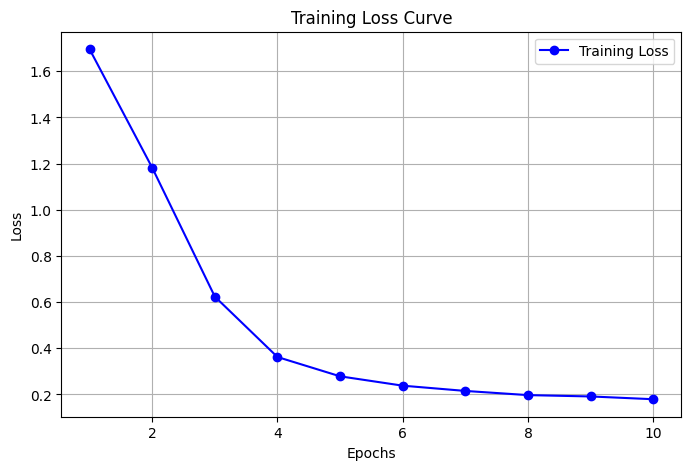

In [36]:
# Sample loss values from training
epochs = list(range(1, 11))  # Number of epochs
loss_values = [1.6956, 1.1823, 0.6239, 0.3623, 0.2787, 0.2382, 0.2154, 0.1973, 0.1915, 0.1795]  # Your recorded losses

# Plot the loss curve
plt.figure(figsize=(8, 5))
plt.plot(epochs, loss_values, marker='o', linestyle='-', color='b', label="Training Loss")

# Labels and title
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss Curve")
plt.legend()
plt.grid()
plt.show()

In [35]:
# Validation loop
model.eval()  # Set model to evaluation mode
correct, total = 0, 0

with torch.no_grad():
    for images, labels in test_dataloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)

        _, predicted = torch.max(outputs, 1)  # Get predicted labels
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = correct / total * 100

print(f"Validation Accuracy: {accuracy:.2f}%")

Validation Accuracy: 90.23%
